In [1]:
library(fpp3)

── Attaching packages ────────────────────────────────────────────── fpp3 0.5 ──

✔ tibble      3.2.1     ✔ tsibble     1.1.3
✔ dplyr       1.1.4     ✔ tsibbledata 0.4.1
✔ tidyr       1.3.0     ✔ feasts      0.3.1
✔ lubridate   1.9.3     ✔ fable       0.3.3
✔ ggplot2     3.4.4     ✔ fabletools  0.3.4

── Conflicts ───────────────────────────────────────────────── fpp3_conflicts ──
✖ lubridate::date()    masks base::date()
✖ dplyr::filter()      masks stats::filter()
✖ tsibble::intersect() masks base::intersect()
✖ tsibble::interval()  masks lubridate::interval()
✖ dplyr::lag()         masks stats::lag()
✖ tsibble::setdiff()   masks base::setdiff()
✖ tsibble::union()     masks base::union()



In [9]:
options(repr.plot.width = 20, repr.plot.height = 5)

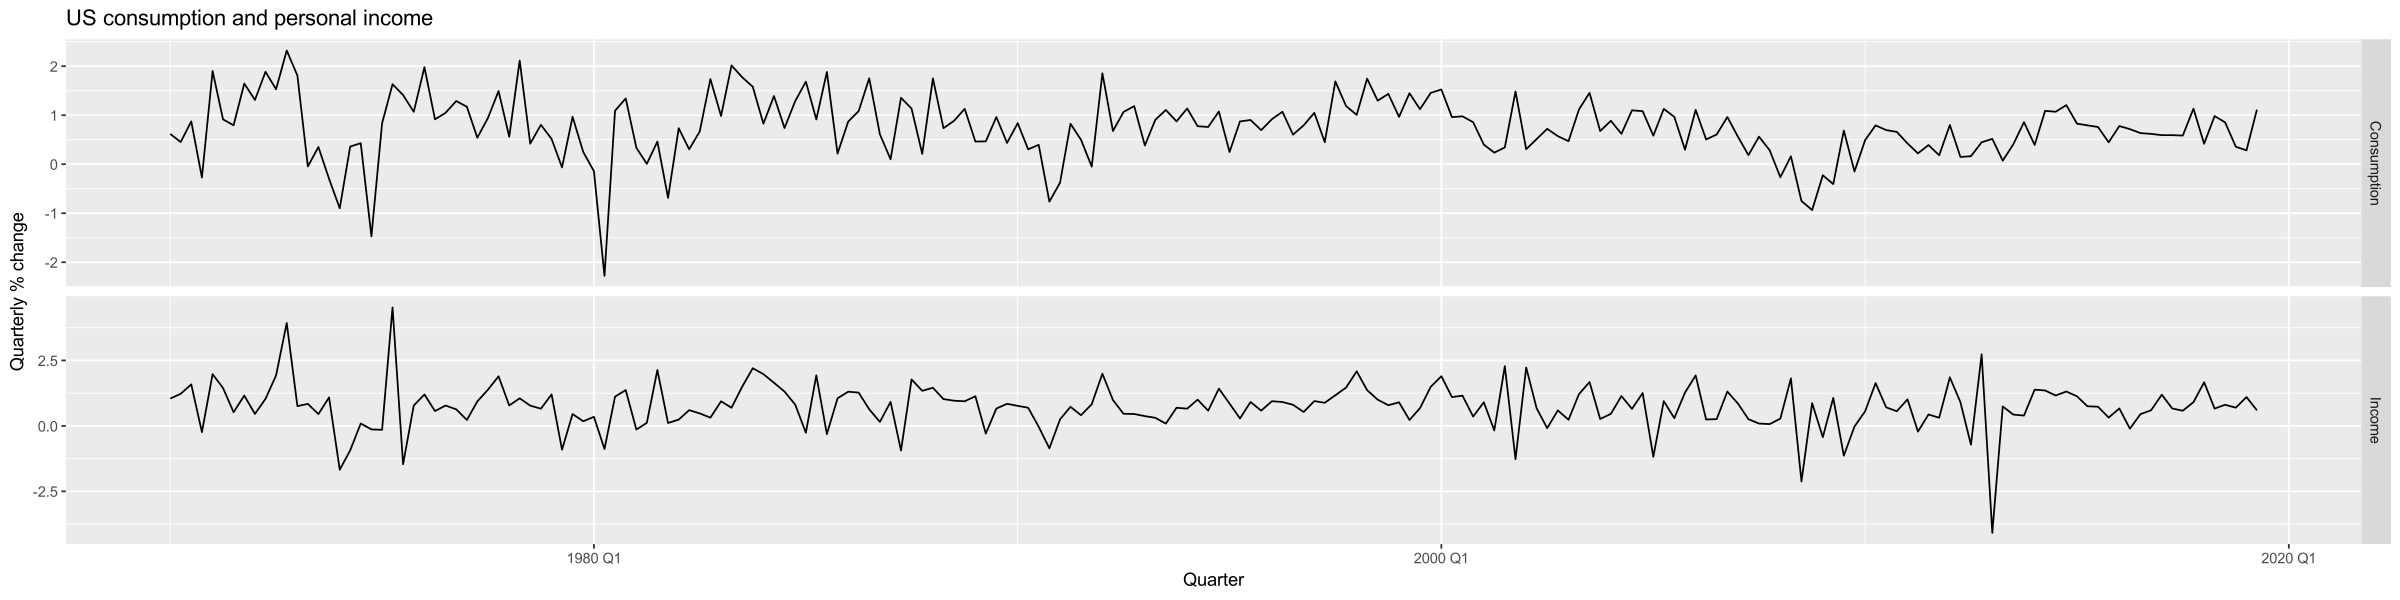

In [11]:
us_change |> pivot_longer(c(Consumption, Income), names_to = "var", values_to = "value") |> ggplot(aes(x = Quarter, y = value)) + geom_line() +  facet_grid(vars(var), scales = "free_y") + labs(title = "US consumption and personal income", y = "Quarterly % change")

In [13]:
fit <- us_change |> model(ARIMA(Consumption ~ Income))
report(fit)

Warning message:
“1 error encountered for ARIMA(Consumption ~ Income)
[1] The `urca` package must be installed to use this functionality. It can be installed with install.packages("urca")
”


Series: Consumption 
Model: NULL model 
NULL model

10.3 -- Forecasting

Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Removed 8 rows containing missing values (`()`).”


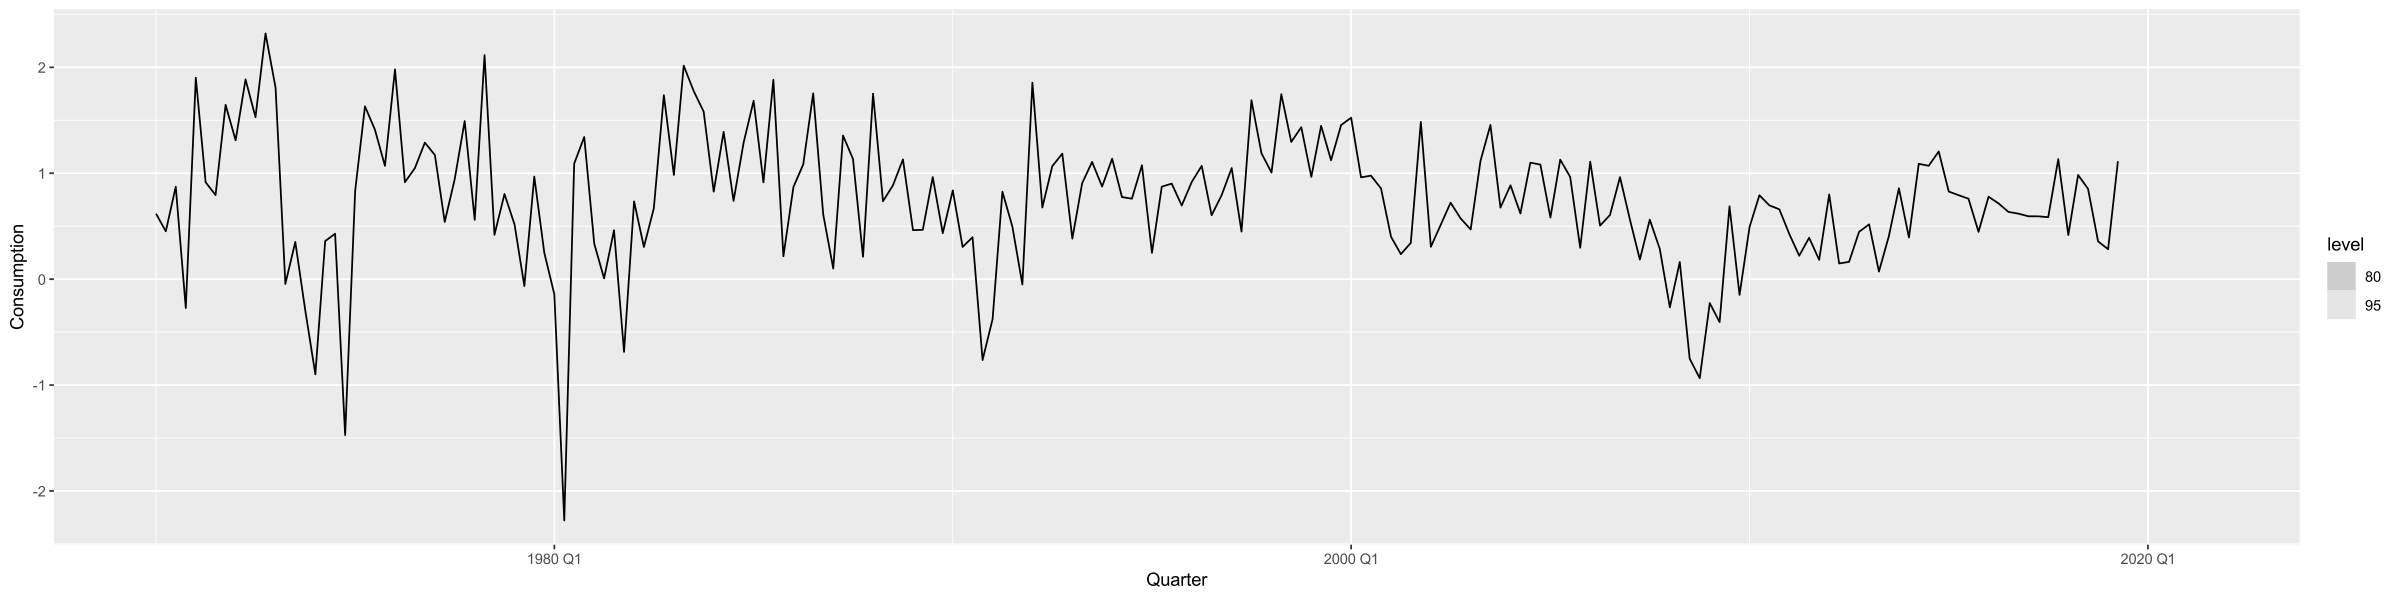

In [22]:
us_change_future <- new_data(us_change, 8) |>
mutate(Income = mean(us_change$Income))


forecast(fit, new_data = us_change_future) |> autoplot(us_change)

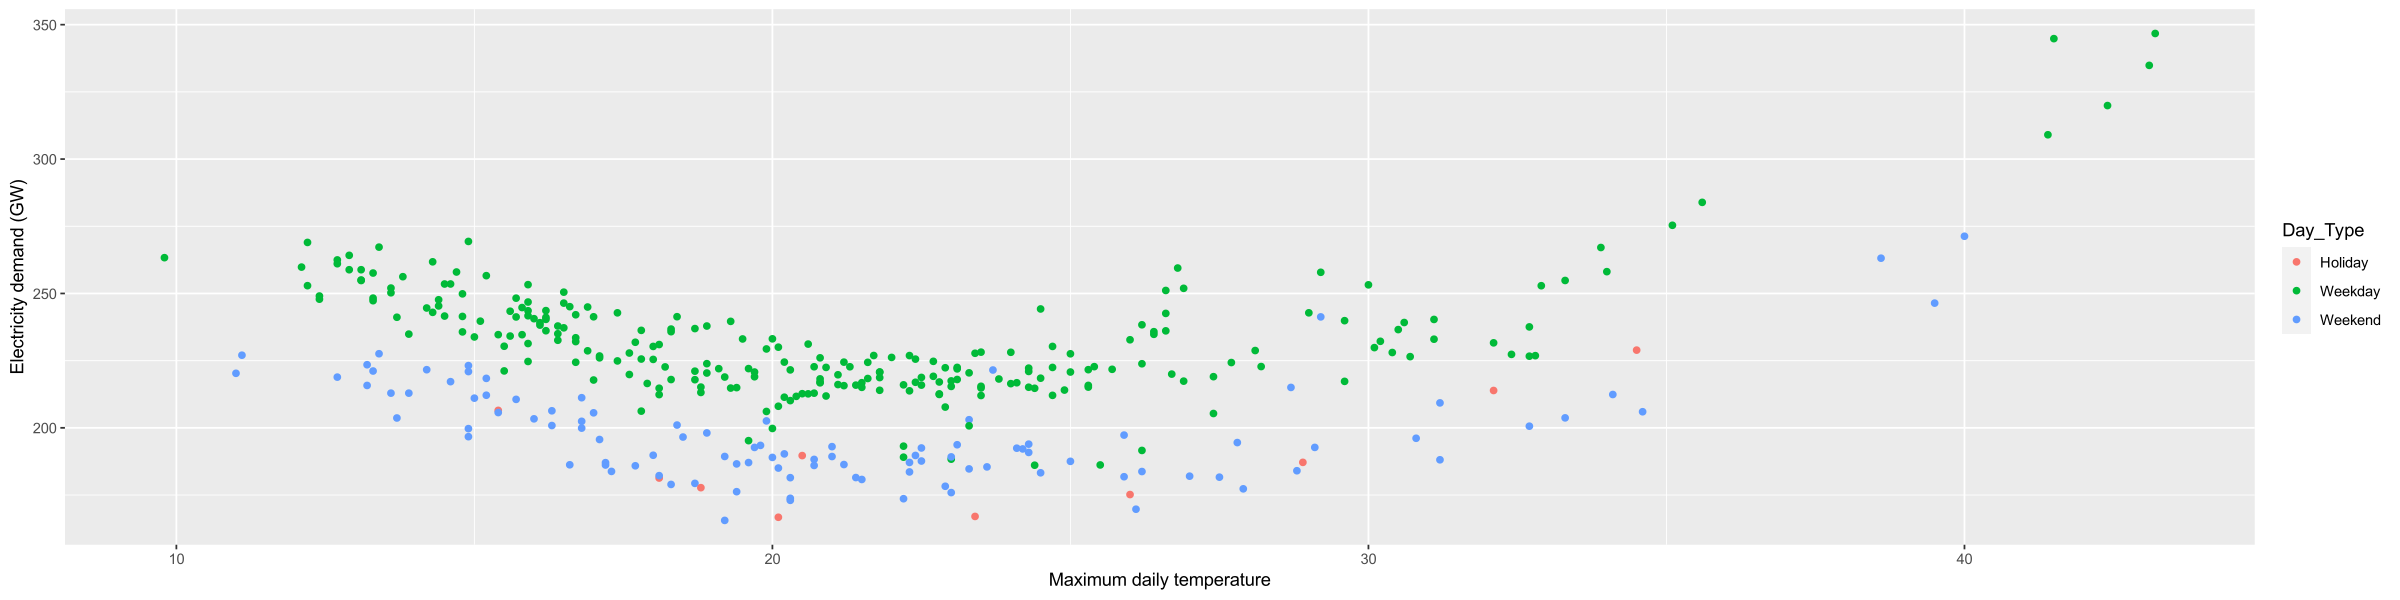

In [27]:
# Example: Forecasting electricity demand

vic_elec_daily <- vic_elec |>
  filter(year(Time) == 2014) |>
  index_by(Date = date(Time)) |>
  summarise(
    Demand = sum(Demand) / 1e3,
    Temperature = max(Temperature),
    Holiday = any(Holiday)
  ) |>
  mutate(Day_Type = case_when(
    Holiday ~ "Holiday",
    wday(Date) %in% 2:6 ~ "Weekday",
    TRUE ~ "Weekend"
  ))

vic_elec_daily |>
  ggplot(aes(x = Temperature, y = Demand, colour = Day_Type)) +
  geom_point() +
  labs(y = "Electricity demand (GW)",
       x = "Maximum daily temperature")

In [28]:
head(vic_elec_daily)

Date,Demand,Temperature,Holiday,Day_Type
<date>,<dbl>,<dbl>,<lgl>,<chr>
2014-01-01,175.1850,26.0,TRUE,Holiday
2014-01-02,188.3506,23.0,FALSE,Weekday
2014-01-03,189.0856,22.2,FALSE,Weekday
2014-01-04,173.7976,20.3,FALSE,Weekend
2014-01-05,169.7328,26.1,FALSE,Weekend
2014-01-06,195.2411,19.6,FALSE,Weekday


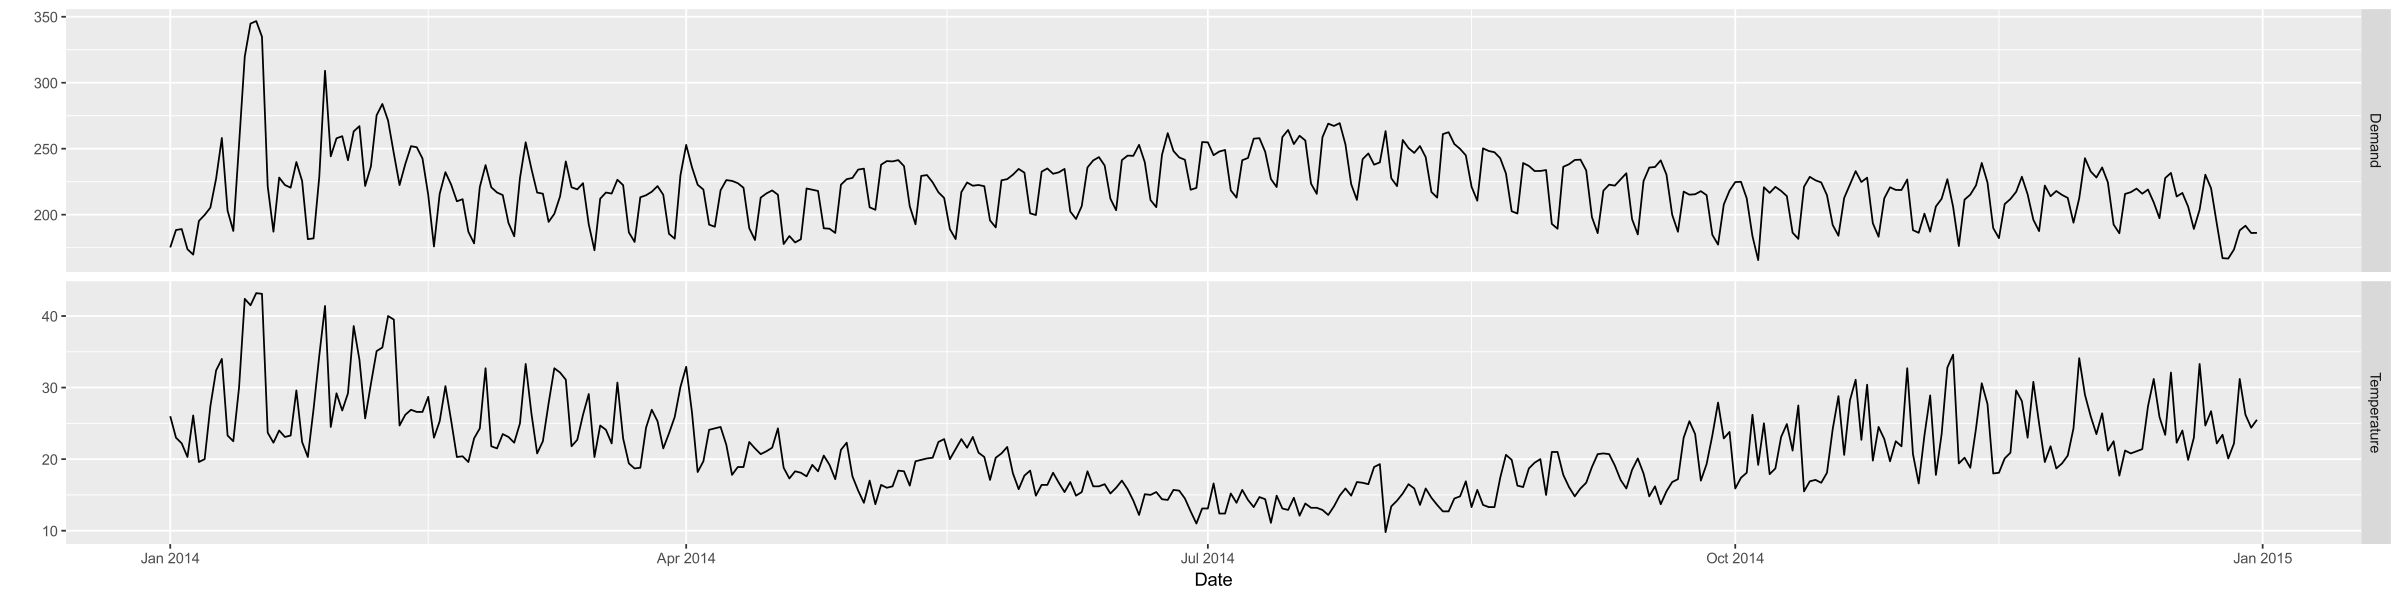

In [30]:
vic_elec_daily |> pivot_longer(c(Demand, Temperature)) |> ggplot(aes(x = Date, y = value)) + geom_line() + facet_grid(name ~ ., scales = "free_y") + ylab("")

Warning message:
“1 error encountered for ARIMA(Demand ~ Temperature + I(Temperature^2) + (Day_Type == 
    "Weekday"))
[1] The `urca` package must be installed to use this functionality. It can be installed with install.packages("urca")
”


ERROR: Error in na.contiguous.default(as.ts(x)): all times contain an NA


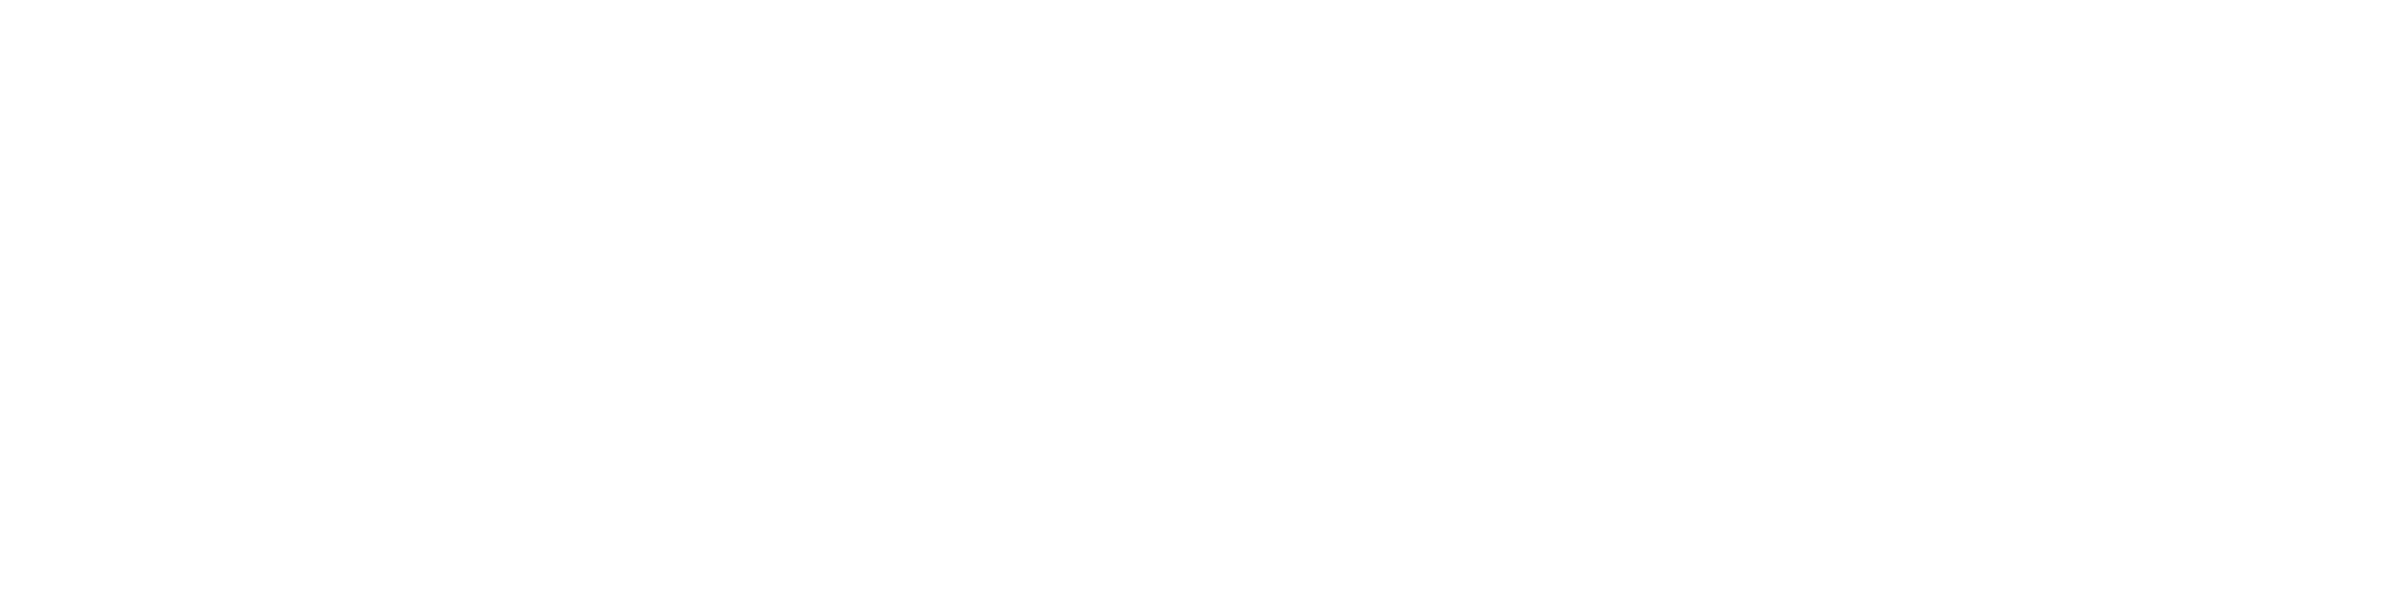

In [31]:
fit <- vic_elec_daily |>
  model(ARIMA(Demand ~ Temperature + I(Temperature^2) +
                (Day_Type == "Weekday")))
fit |> gg_tsresiduals()

10.4 -- Stochastic and deterministic trends

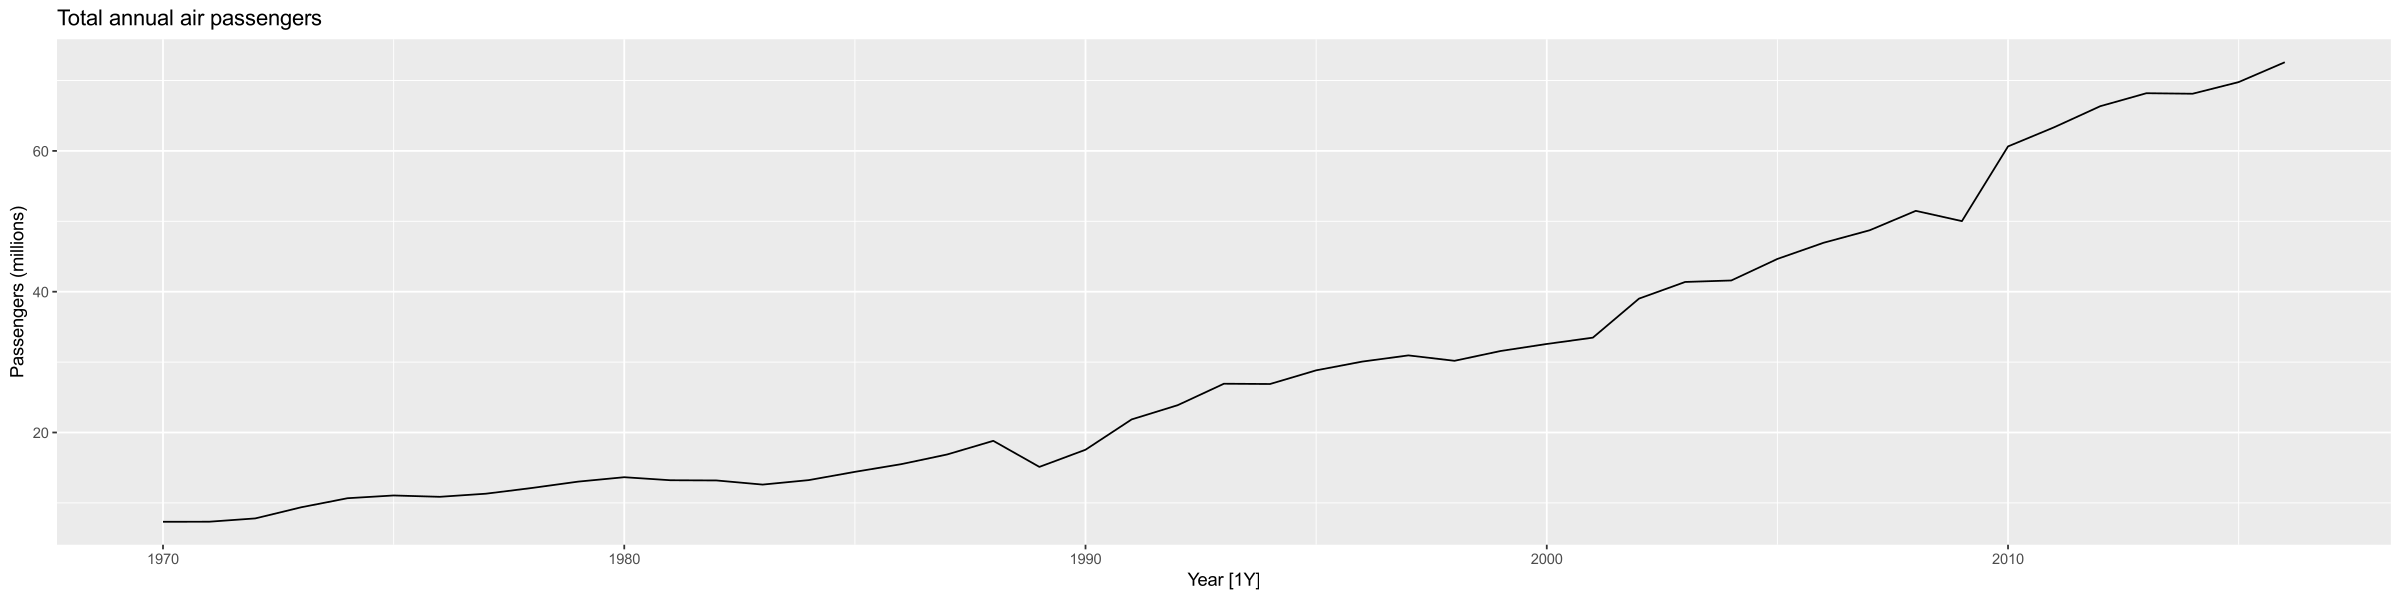

In [32]:
aus_airpassengers |> autoplot(Passengers) + labs(y = "Passengers (millions)", title = "Total annual air passengers")

In [33]:
# We will fit both a deterministic and a stochastic trend model to these data

fit_deterministic <- aus_airpassengers |> model(deterministic = ARIMA(Passengers ~ 1 + trend() + pdq(d=0)))

In [34]:
report(fit_deterministic)

Series: Passengers 
Model: LM w/ ARIMA(1,0,0) errors 

Coefficients:
         ar1  trend()  intercept
      0.9564   1.4151     0.9014
s.e.  0.0362   0.1972     7.0751

sigma^2 estimated as 4.343:  log likelihood=-100.88
AIC=209.77   AICc=210.72   BIC=217.17


In [36]:
fit_stochastic <- aus_airpassengers |> model(stochastic = ARIMA(Passengers ~ pdq(d = 1)))
report(fit_stochastic)

Series: Passengers 
Model: ARIMA(0,1,0) w/ drift 

Coefficients:
      constant
        1.4191
s.e.    0.3014

sigma^2 estimated as 4.271:  log likelihood=-98.16
AIC=200.31   AICc=200.59   BIC=203.97


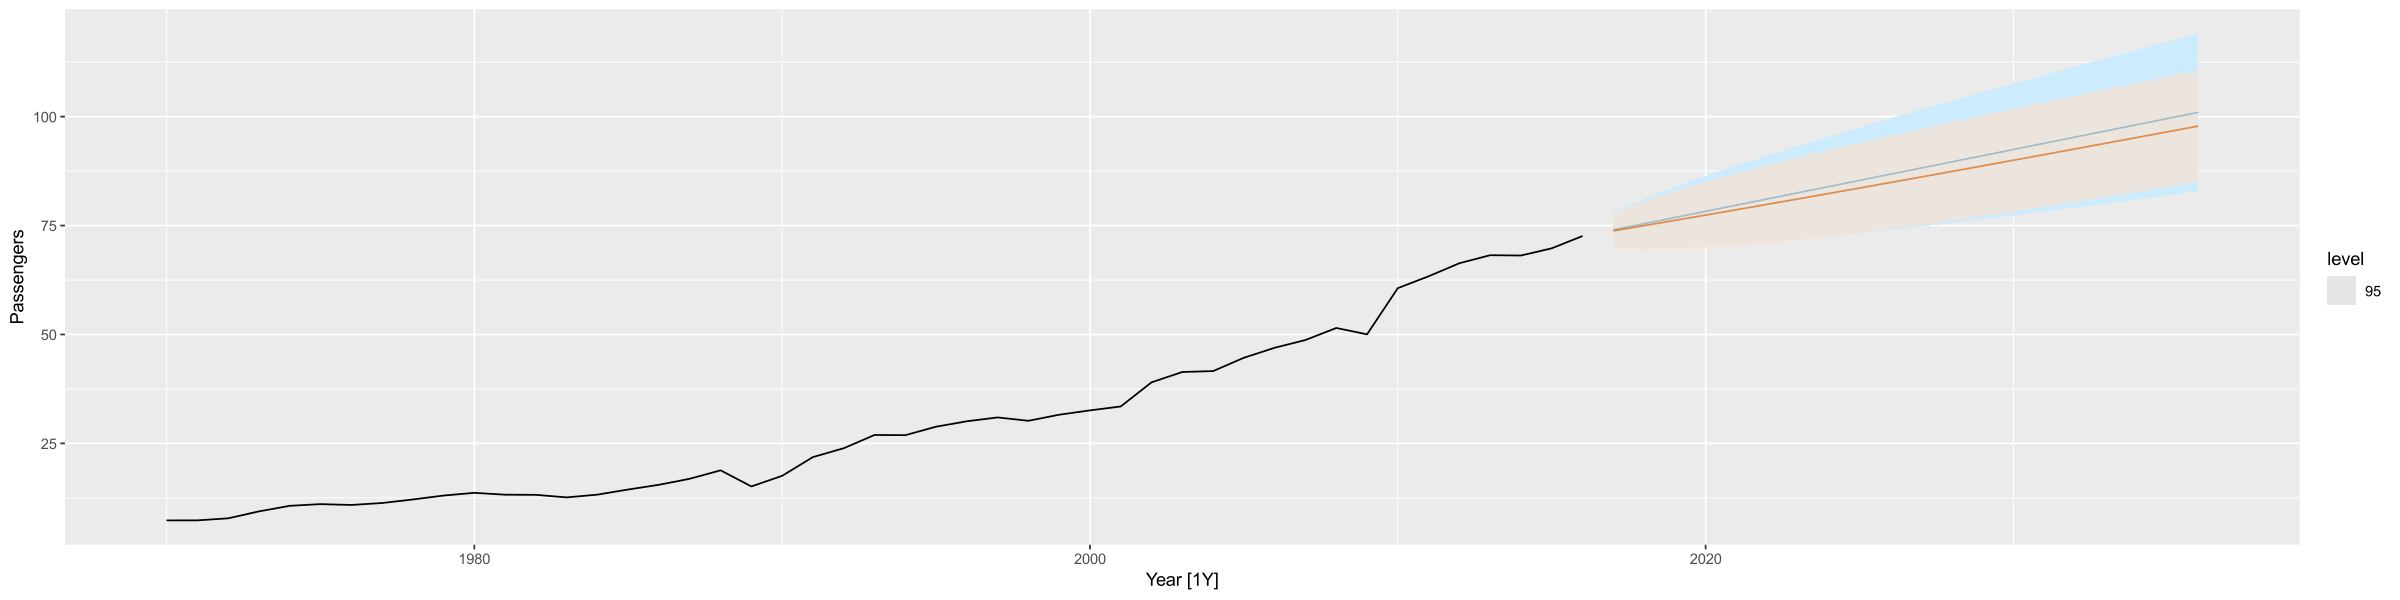

In [38]:
aus_airpassengers |> autoplot(Passengers) + autolayer(fit_stochastic |> forecast(h = 20), colour = "#0072B2", level=95) + autolayer(fit_deterministic |> forecast(h=20), colour="#D55E00", alpha = 0.65, level = 95)